In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns
import sklearn
from sklearn import datasets
import torch

# Visualization code

In [3]:
def draw_contour(ax, f, xlow, xhigh, ylow, yhigh):
    x,y = np.meshgrid(np.arange(xlow, xhigh, 0.1), np.arange(ylow, yhigh, 0.1))
    #Slow loop
    z = np.zeros(np.shape(x))
    for i in np.arange(0, np.shape(x)[0]):
        for j in np.arange(0, np.shape(x)[1]):
            z[i,j] = f(np.array((x[i,j],y[i,j])))
    ax.contour(x,y,z, levels=10, alpha=0.2)
    
def draw_search_path(ax, steps):
    linecoll = mpl.collections.LineCollection(zip(steps[:-1], steps[1:]), colors='r')
    linecoll.set_linestyle('-')
    ax.add_collection(linecoll)
    ax.scatter(steps[0][0], steps[0][1], marker='s', c='r') #Start point
    ax.scatter(steps[-1][0], steps[-1][1], marker='*', c='b') #End point
    ax.scatter([pos[0] for pos in steps[1:-1]], [pos[1] for pos in steps[1:-1]], marker='.', c = 'r') #Middle points


def illustrate_search(ax, f, steps, xlow, xhigh, ylow, yhigh):
    print("Iteration sequence:")
    print(steps)
    draw_contour(ax, f, xlow, xhigh, ylow, yhigh)
    draw_search_path(ax, steps)

In [4]:
class QuadraticObjective(object):
    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c
    
    def value(self, p):
        return 0.5 * np.dot(p, np.dot(self.a, p)) + np.dot(self.b, p) + self.c
    
    def grad(self, p):
        return np.dot(self.a, p) + self.b
    
    def hess(self, p):
        return self.a

Algorithms
=========

In [5]:
def fake_algorithm():
    return [[-2,0],[-1,-1],[3,-1]]

Algorithm tests
==============

In [6]:
simple_quad_obj = QuadraticObjective(np.eye(2), np.array([-2.0, 4.0]), 5.0)
stretched_quad_obj = QuadraticObjective(np.array([[10.0,-1.0],[-1.0, 2.0]]), np.array([3.0, 3.0]), 2.0)

Iteration sequence:
[[-2, 0], [-1, -1], [3, -1]]


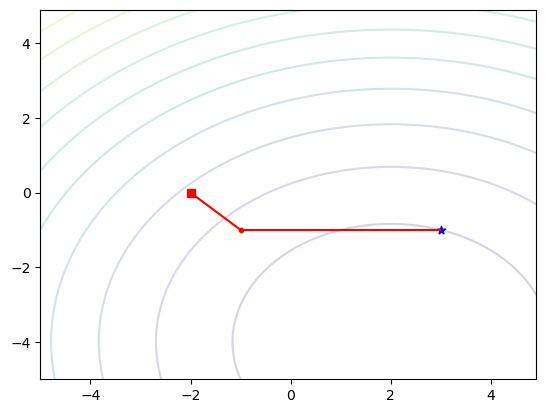

In [7]:
fig, ax = plt.subplots(1,1)
illustrate_search(ax, simple_quad_obj.value, fake_algorithm(), -5, 5, -5, 5)
plt.draw()
plt.show()

Iteration sequence:
[[-2, 0], [-1, -1], [3, -1]]


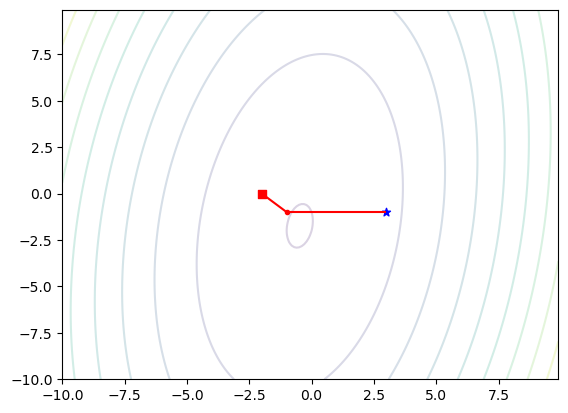

In [8]:
fig, ax = plt.subplots(1,1)
illustrate_search(ax, stretched_quad_obj.value, fake_algorithm(), -10, 10, -10, 10)
plt.draw()
plt.show()

# Gradient descent and Newton's Method

In [9]:
def simple_stop_crit(points, step_dir, tolerance = 1e-2):
    return np.linalg.norm(step_dir) <= tolerance

def backtracking(f, grad, x, d, init_step = 1.0, dec = 0.1, contraction=0.4):
    orig_val = f(x)
    orig_grad = grad(x)
    step = init_step
    while f(x  + step * d) > orig_val + dec * step * np.dot(orig_grad, d):
        step *= contraction
        if step < 1e-20:
            raise 'Backtracking failed'
    return step

def descent_method(x_init, dir_finder, size_finder, stop_crit):
    points = [x_init]
    cont = True
    
    x = x_init
    while cont:
        step_dir = dir_finder(x)
        if stop_crit(points, step_dir):
            cont = False
        step_size = size_finder(x, step_dir)
        x = x + step_size*step_dir
        
        points.append(x)

    return points

def steepest_descent(f, grad, x_0):
    return descent_method(x_0,
                          lambda x : -grad(x),
                          lambda x, d : backtracking(f, grad, x, d),
                          lambda ps, x: simple_stop_crit(ps, x))

def newton(f, grad, hess, x_0):
    return descent_method(x_0,
                          lambda x : -np.linalg.solve(hess(x), grad(x)),
                          lambda x, d : backtracking(f, grad, x, d),
                          lambda ps, x: simple_stop_crit(ps, x))

### Steepest Descent

Iteration sequence:
[array([-2.,  0.]), array([ 2., -4.]), array([ 2., -4.])]


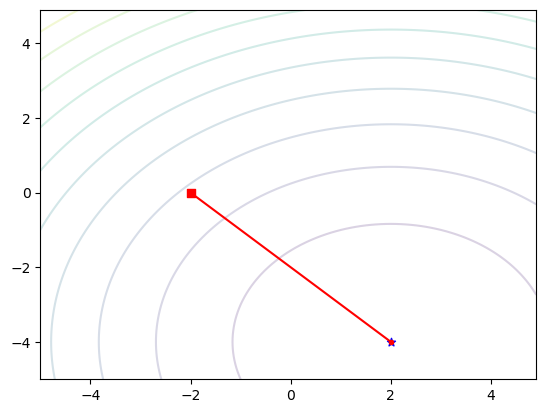

In [10]:
fig, ax = plt.subplots(1,1)
illustrate_search(ax, simple_quad_obj.value, 
                  steepest_descent(simple_quad_obj.value, simple_quad_obj.grad, np.array([-2.0,0.0])),
                  -5, 5, -5, 5)

Iteration sequence:
[array([-2.,  4.]), array([1.36, 1.92]), array([-0.9888,  1.0432]), array([0.280192, 0.071168]), array([-0.63672832, -0.38677504]), array([-0.15984701, -0.84488356]), array([-0.51927316, -1.08009634]), array([-0.34125152, -1.29754922]), array([-0.48285696, -1.41693371]), array([-0.41699522, -1.52077204]), array([-0.4731264 , -1.58084422]), array([-0.4129585, -1.7054194]), array([-0.50509201, -1.70575855]), array([-0.44986617, -1.72073054]), array([-0.48539719, -1.72207535]), array([-0.46429374, -1.72867479]), array([-0.47801172, -1.72978586]), array([-0.46995871, -1.73273626]), array([-0.47526258, -1.73345405]), array([-0.4721951 , -1.73479076]), array([-0.47424946, -1.73520894]), array([-0.47308375, -1.73582199])]


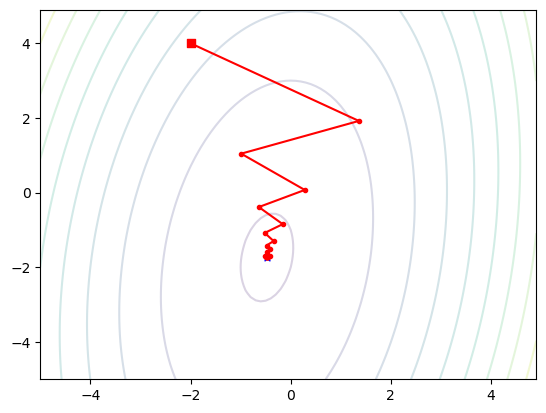

In [11]:
fig, ax = plt.subplots(1,1)
illustrate_search(ax, stretched_quad_obj.value, 
                  steepest_descent(stretched_quad_obj.value, stretched_quad_obj.grad, np.array([-2.0,4.0])),
                  -5, 5, -5, 5)

### Newton

Iteration sequence:
[array([-2.,  0.]), array([ 2., -4.]), array([ 2., -4.])]


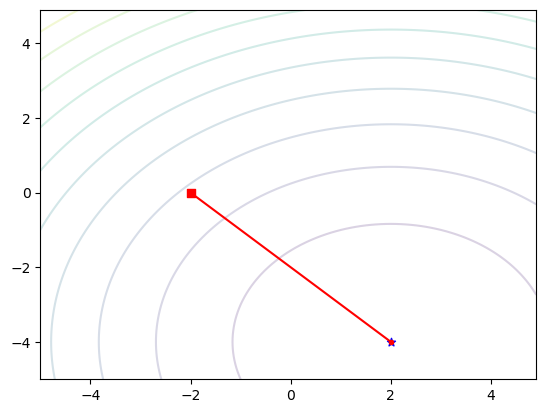

In [12]:
fig, ax = plt.subplots(1,1)
illustrate_search(ax, simple_quad_obj.value, 
                  newton(simple_quad_obj.value, simple_quad_obj.grad, simple_quad_obj.hess, np.array([-2.0,0.0])),
                  -5, 5, -5, 5)

Iteration sequence:
[array([-2.,  4.]), array([-0.47368421, -1.73684211]), array([-0.47368421, -1.73684211])]


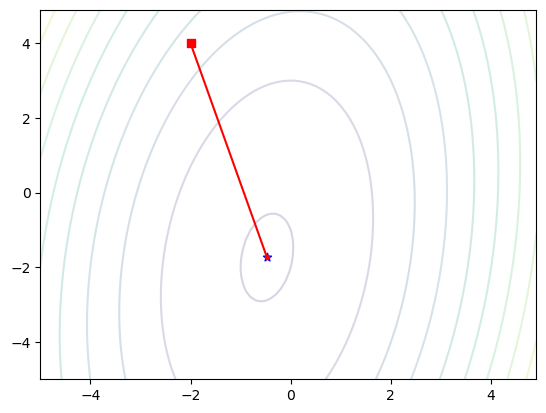

In [13]:
fig, ax = plt.subplots(1,1)
illustrate_search(ax, stretched_quad_obj.value, 
                  newton(stretched_quad_obj.value, stretched_quad_obj.grad, stretched_quad_obj.hess, np.array([-2.0,4.0])),
                  -5, 5, -5, 5)

# CVXOPT-SVM

There is an in-built, but we'll do it ourselves this time.

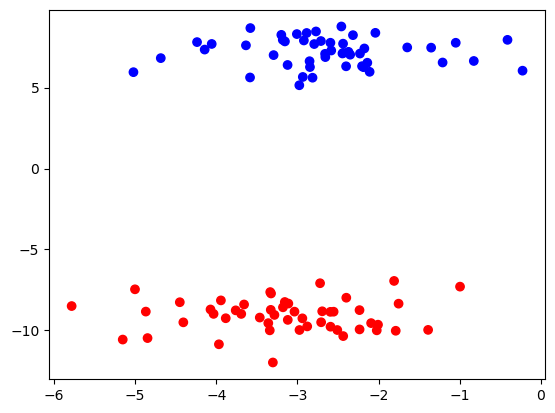

In [14]:
(samples, classifications) = sklearn.datasets.make_blobs(centers=2)
classifications = np.array([2 * float(c) - 1 for c in classifications]) #Map (0,1) to (-1,1)
plt.scatter(samples[:,0], samples[:,1], c=['red' if c < 0 else 'blue' for c in classifications])

# (Stochastic) subgradient

(Exercise) Solve the "SVM problem" again, using a subgradient method and constant step size.

# Simple neural network
Using a new blob of data we'll train a simple network with pytorch.

In [1]:
(samples, classifications) = sklearn.datasets.make_blobs(n_samples=1000, centers=2)
plt.scatter(samples[:,0], samples[:,1], c=['red' if c == 0 else 'blue' for c in classifications])
training_length = 600 #400 for testing

NameError: name 'sklearn' is not defined